In [19]:
pip install datasets

In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 17.5 MB/s eta 0:00:00


In [3]:
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
import numpy as np
from datasets import Dataset
import pandas as pd
import re
import matplotlib.pyplot as plt

from prettytable import PrettyTable
from sklearn.metrics.pairwise import cosine_similarity
import random
import faiss

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
# Load the dataset
dataset = load_dataset("sentence-transformers/squad")

# Load the bi-encoder model
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

# Extract the questions and answers
questions = dataset['train']['question'][:400]
answers = dataset['train']['answer'][:400]


# Compute embeddings for questions and answers
question_embeddings = model.encode(questions, convert_to_tensor=True, show_progress_bar=True)
answer_embeddings = model.encode(answers, convert_to_tensor=True, show_progress_bar=True)

# Save embeddings for further analysis
question_embeddings_np = question_embeddings.cpu().numpy()
answer_embeddings_np = answer_embeddings.cpu().numpy()

# Prepare a DataFrame for better data handling
data = pd.DataFrame({'question': questions, 'answer': answers})
data['question_embedding'] = list(question_embeddings_np)
data['answer_embedding'] = list(answer_embeddings_np)

data.head()


data['question_embedding'] = data['question_embedding'].apply(lambda x: ','.join(map(str, x)))
data['answer_embedding'] = data['answer_embedding'].apply(lambda x: ','.join(map(str, x)))


data.to_csv('embeddings_zad3.csv', index=False)

README.md:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [6]:
data = pd.read_csv('embeddings_zad3.csv')
questions = data['question'].to_list()
answers = data['answer'].to_list()

In [7]:
len(questions)

400

In [8]:
len(answers)

400

In [9]:
# data.to_csv('embeddings_zad3.csv')

In [9]:
len(data)

400

In [10]:
data.head()

,question,answer,question_embedding,answer_embedding
0,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...","0.06718837,-0.12966423,-0.37205565,0.006261712...","0.09202485,-0.11509832,-0.09249758,0.59628886,..."
1,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...","-0.075725846,-0.036807496,-0.44445625,0.164457...","0.09202485,-0.11509832,-0.09249758,0.59628886,..."
2,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...","-0.17233576,0.036861785,-0.42555937,0.29381537...","0.09202485,-0.11509832,-0.09249758,0.59628886,..."
3,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...","-0.030828971,-0.057603903,-0.40976864,0.173191...","0.09202485,-0.11509832,-0.09249758,0.59628886,..."
4,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...","-0.026436292,-0.012920156,-0.41351086,0.218337...","0.09202485,-0.11509832,-0.09249758,0.59628886,..."


In [11]:
len(data['question'])

400

In [12]:
len(data['question'].unique())

499

# Przygotowanie danych

In [12]:


def fix_and_convert_to_array(embedding_str):

    fixed_str = re.sub(r'(\d)(\s)(-?\d)', r'\1,\3', embedding_str.strip())
    fixed_str = fixed_str.replace('[', '').replace(']', '')
    fixed_list = list(map(float, fixed_str.split(',')))
    return np.array(fixed_list)


data['question_embedding'] = data['question_embedding'].apply(fix_and_convert_to_array)
data['answer_embedding'] = data['answer_embedding'].apply(fix_and_convert_to_array)

question_embeddings_np = np.vstack(data['question_embedding'].to_numpy())
answer_embeddings_np = np.vstack(data['answer_embedding'].to_numpy())


# Wyszukiwanie semantyczne

In [13]:


def semantic_search(query, answer_embedding, answer_texts, top_k=5):
    query_embedding = model.encode([query], convert_to_tensor=True)
    cosine_scores = cosine_similarity(
        query_embedding.cpu().numpy(), answer_embedding
    )
    top_k_indices = np.argsort(cosine_scores[0])[-top_k:][::-1]
    return [(cosine_scores[0][i], answer_texts[i]) for i in top_k_indices]


def get_simple_answer_semantic(query, k=20):
    print('-------------------------------------------------')
    print('SEMANTIC')
    print('-------------------------------------------------')
    results = semantic_search(query, answer_embeddings_np, answers, top_k=k)
    for rank, (score, ans) in enumerate(results):
        print(f"Rank {rank+1}: Answer: {ans}, Score: {score:.4f}")



# Index FAISS

In [14]:

hf_dataset = Dataset.from_pandas(data)


hf_dataset = hf_dataset.add_faiss_index(column="answer_embedding")

def faiss_search_with_hf(query, hf_dataset, model, top_k=5):

    query_embedding = model.encode(query, convert_to_tensor=True).cpu().numpy()

    scores, examples = hf_dataset.get_nearest_examples(
        index_name="answer_embedding",
        query=query_embedding,  # Single query embedding
        k=top_k
    )

    return list(zip(scores, examples["answer"]))


def faiss_search_manual(query, embeddings, answers, model, top_k=5, nlist=10):


    d = embeddings.shape[1]  # Wymiar osadzeń

    # Tworzenie IndexIVFFlat z quantizerem IndexFlatL2
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist)

    # Trening indeksu (wymaga podania danych treningowych)
    index.train(embeddings)  # Klastrowanie osadzeń
    index.add(embeddings)    # Dodanie osadzeń do indeksu

    # Kodowanie zapytania
    query_embedding = model.encode(query, convert_to_tensor=True).cpu().numpy().astype("float32")

    # Wyszukiwanie K-najbliższych sąsiadów
    _, indices = index.search(np.array([query_embedding]), k=top_k)

    # Mapowanie wyników na odpowiedzi
    results = [answers[indices[0][i]] for i in range(len(indices[0]))]

    return results


def get_simple_answer_faiss(query, k=20):
    faiss_results = faiss_search_with_hf(query, hf_dataset, model, top_k=20)

    faiss_results
    print('-------------------------------------------------')
    print('FAISS')
    print('-------------------------------------------------')
    print(f"Query: {query}")
    for rank, (score, answer) in enumerate(faiss_results):
        print(f"Rank {rank+1}: Answer: {answer}, Score: {score:.4f}")

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
query = 'What is the Paris?'
get_simple_answer_faiss(query)
get_simple_answer_semantic(query)

-------------------------------------------------
FAISS
-------------------------------------------------
Query: What is the Paris?
Rank 1: Answer: The University of Notre Dame du Lac (or simply Notre Dame /ˌnoʊtərˈdeɪm/ NOH-tər-DAYM) is a Catholic research university located adjacent to South Bend, Indiana, in the United States. In French, Notre Dame du Lac means "Our Lady of the Lake" and refers to the university's patron saint, the Virgin Mary. The main campus covers 1,250 acres in a suburban setting and it contains a number of recognizable landmarks, such as the Golden Dome, the "Word of Life" mural (commonly known as Touchdown Jesus), and the Basilica., Score: 41.4431
Rank 2: Answer: The University of Notre Dame du Lac (or simply Notre Dame /ˌnoʊtərˈdeɪm/ NOH-tər-DAYM) is a Catholic research university located adjacent to South Bend, Indiana, in the United States. In French, Notre Dame du Lac means "Our Lady of the Lake" and refers to the university's patron saint, the Virgin Mary

In [18]:
query = 'What is the Notre Dame?'
get_simple_answer_faiss(query)
get_simple_answer_semantic(query)

-------------------------------------------------
FAISS
-------------------------------------------------
Query: What is the Notre Dame?
Rank 1: Answer: The University of Notre Dame du Lac (or simply Notre Dame /ˌnoʊtərˈdeɪm/ NOH-tər-DAYM) is a Catholic research university located adjacent to South Bend, Indiana, in the United States. In French, Notre Dame du Lac means "Our Lady of the Lake" and refers to the university's patron saint, the Virgin Mary. The main campus covers 1,250 acres in a suburban setting and it contains a number of recognizable landmarks, such as the Golden Dome, the "Word of Life" mural (commonly known as Touchdown Jesus), and the Basilica., Score: 26.2679
Rank 2: Answer: The University of Notre Dame du Lac (or simply Notre Dame /ˌnoʊtərˈdeɪm/ NOH-tər-DAYM) is a Catholic research university located adjacent to South Bend, Indiana, in the United States. In French, Notre Dame du Lac means "Our Lady of the Lake" and refers to the university's patron saint, the Virgin

In [19]:
query = 'Does Beoynce have a husband?'
#query = 'Who is Beyoncé married to?'
get_simple_answer_faiss(query)
get_simple_answer_semantic(query)

#niepoprawne

-------------------------------------------------
FAISS
-------------------------------------------------
Query: Does Beoynce have a husband?
Rank 1: Answer: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy"., Score: 46.0854
Rank 2: Answer: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwrite

In [20]:
query = 'How old is the king Mahendra?'
get_simple_answer_faiss(query)
get_simple_answer_semantic(query)

#poprawne

-------------------------------------------------
FAISS
-------------------------------------------------
Query: How old is the king Mahendra?
Rank 1: Answer: A self-described "modern-day feminist", Beyoncé creates songs that are often characterized by themes of love, relationships, and monogamy, as well as female sexuality and empowerment. On stage, her dynamic, highly choreographed performances have led to critics hailing her as one of the best entertainers in contemporary popular music. Throughout a career spanning 19 years, she has sold over 118 million records as a solo artist, and a further 60 million with Destiny's Child, making her one of the best-selling music artists of all time. She has won 20 Grammy Awards and is the most nominated woman in the award's history. The Recording Industry Association of America recognized her as the Top Certified Artist in America during the 2000s decade. In 2009, Billboard named her the Top Radio Songs Artist of the Decade, the Top Female Artis

# METRYKI

## Ground truths

In [21]:
question_answer_dict = data.drop_duplicates(subset=['question', 'answer']).set_index('question')['answer'].to_dict()
len(question_answer_dict)

499

In [22]:
duplicated_questions = data[data.duplicated(subset='question', keep=False)]
duplicated_question_answer_dict = duplicated_questions.groupby('question')['answer'].apply(list).to_dict()
len(duplicated_question_answer_dict)

1

In [23]:

duplicated_question_unique_answer = {
    question: answers for question, answers in duplicated_question_answer_dict.items() if len(answers) == len(set(answers))
}

len(duplicated_question_unique_answer)


1

In [24]:
duplicated_question_unique_answer

{'When did Beyoncé release her first solo album?': ['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
  'Beyoncé\'s first solo recording was a feature on Jay Z\'s "\'03 Bonnie & Clyde" that was released in October 2002, peaking at number four on the U.S. Billboard Hot 100 chart. Her first solo album Dangerously in Love was released on June 24, 200

In [26]:
complete_dict = question_answer_dict | duplicated_question_answer_dict
len(complete_dict)

499

In [27]:
# complete_dict['Who wrote the Divine Comedy?']

KeyError: 'Who wrote the Divine Comedy?'

## Recall

In [25]:
# recall@k function
def calculate_recall(actual, predicted, k):

    if isinstance(actual, str):
        actual = [actual]

    act_set = set(actual)
    pred_set = set(predicted[:k])

    result = round(len(act_set & pred_set) / float(len(act_set)), 2)
    return result

In [28]:
def generate_tables(query, semantic_search, faiss_search, correct_answers):
    def format_table(header, rows):
        table = f"{header[0]:<40} | {header[1]:<20}\n"
        table += "-" * 65 + "\n"
        for row in rows:
            table += f"{row[0]:<40} | {row[1]:<20}\n"
        return table

    # Prepare rows for each table
    semantic_rows = [(query, result) for result in semantic_search]
    faiss_rows = [(query, result) for result in faiss_search]
    correct_rows = [(query, answer) for answer in correct_answers]

    # Generate tables
    semantic_table = format_table(["Query", "Semantic Result"], semantic_rows)
    faiss_table = format_table(["Query", "FAISS Result"], faiss_rows)
    correct_table = format_table(["Query", "Correct Answer"], correct_rows)

    return semantic_table, faiss_table, correct_table

In [29]:
def compare_answers(query, model, top_k=5, answer_embeddings = answer_embeddings_np, answer_texts=answers, hf_dataset= hf_dataset, correct_answers_dict=complete_dict, is_faiss_automatic= True):
    query_embedding = model.encode([query], convert_to_tensor=True)
    cosine_scores = cosine_similarity(query_embedding.cpu().numpy(), answer_embeddings)
    top_k_indices = np.argsort(cosine_scores[0])[-top_k:][::-1]

    semantic_search = [answer_texts[i] for i in top_k_indices]

    if is_faiss_automatic:
        scores, examples = hf_dataset.get_nearest_examples(
            index_name="answer_embedding",
            query=query_embedding.cpu().numpy(),
            k=top_k
        )

        faiss_search = examples['answer']
    else:
        faiss_search = faiss_search_manual(query, answer_embeddings, answer_texts, model, top_k)


    correct_answers = complete_dict[query]

    semantic_table, faiss_table, correct_table = generate_tables(query, semantic_search, faiss_search, correct_answers)
    return semantic_search, faiss_search, correct_answers,   semantic_table, faiss_table, correct_table

def calculate_metric(metric, semantic_search, faiss_search, correct_answers, k):

    if metric == 'recall':
        recall_semantic = calculate_recall( correct_answers, semantic_search, k)

        recall_faiss = calculate_recall(correct_answers, faiss_search, k)

        return [recall_semantic, recall_faiss]


In [30]:

def calculate_and_visualize_recall(query, values, model, print_val = True, is_faiss_automatic=True):
    k_values = values
    recall_values_dict = {}

    for k in values:
        semantic_search, faiss_search, correct_answers,  semantic_table, faiss_table, correct_table = compare_answers(query, model, 50, is_faiss_automatic=is_faiss_automatic)
        result = calculate_metric('recall', semantic_search, faiss_search, correct_answers, k )
        recall_values_dict[k] = result

    if(print_val):
        print("Semantic Search Results:")
        print(semantic_table)
        print("\nFAISS Search Results:")
        print(faiss_table)
        print("\nCorrect Answers:")
        print(correct_table)

        semantic_recall = [recall_values_dict[k][0] for k in k_values]
        faiss_recall = [recall_values_dict[k][1] for k in k_values]

        plt.figure(figsize=(10, 6))
        plt.plot(k_values, semantic_recall, marker='o', label='Semantic Search Recall')
        plt.plot(k_values, faiss_recall, marker='s', label='FAISS Recall')

        plt.title('Recall Values for Semantic Search and FAISS')
        plt.xlabel('k-values')
        plt.ylabel('Recall')
        plt.legend()
        plt.grid(True)
        plt.show()

    return recall_values_dict

In [ ]:
# query = 'Who wrote the Divine Comedy?'
# k_values = [1,2,3,4,5,6,7,8,9,10,15]

# calculate_and_visualize_recall(query, k_values, model, True)

In [31]:
random.seed(42)
queries = random.sample(list(duplicated_question_unique_answer.keys()), 1)
queries

['When did Beyoncé release her first solo album?']

Semantic Search Results:
Query                                    | Semantic Result     
-----------------------------------------------------------------
When did Beyoncé release her first solo album? | Following the disbandment of Destiny's Child in June 2005, she released her second solo album, B'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar". Beyoncé also ventured into acting, with a Golden Globe-nominated performance in Dreamgirls (2006), and starring roles in The Pink Panther (2006) and Obsessed (2009). Her marriage to rapper Jay Z and portrayal of Etta James in Cadillac Records (2008) influenced her third album, I Am... Sasha Fierce (2008), which saw the birth of her alter-ego Sasha Fierce and earned a record-setting six Grammy Awards in 2010, including Song of the Year for "Single Ladies (Put a Ring on It)". Beyoncé took a hiatus from music in 2010 and took over management of her career; her fourth album 4 (2011) was subsequently mellower in t

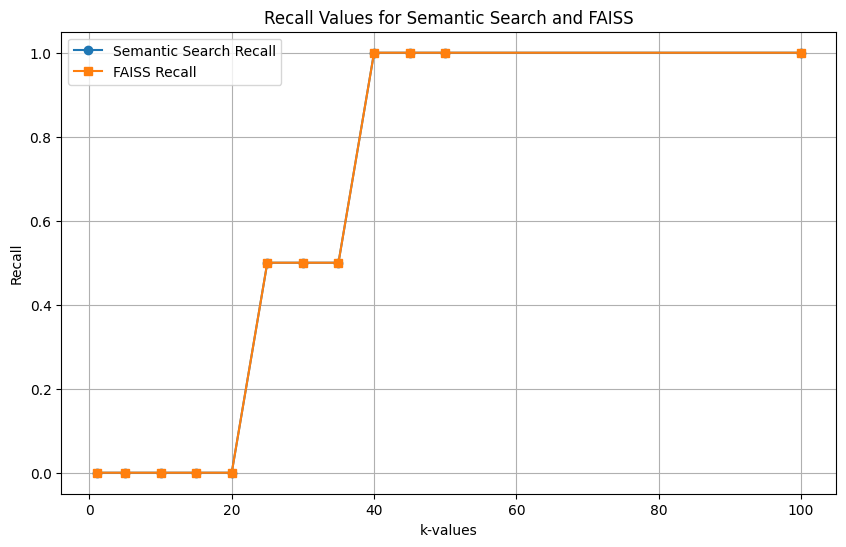

In [32]:
k_values = [1,5,10,15, 20, 25, 30, 35, 40, 45, 50, 100]
for query in queries:
    calculate_and_visualize_recall(query, k_values, model, True)

### Uśrednienie wszystkich pytań

In [ ]:
def plot_average_recall(results_for_query):

    data = []

    for query, results in results_for_query.items():
        for k, values in results.items():
            data.append({"Query": query, "k": k, "Recall_Semantic": values[0], "Recall_FAISS": values[1]})

    df = pd.DataFrame(data)

    average_results = df.groupby("k")[["Recall_Semantic", "Recall_FAISS"]].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(average_results.index, average_results["Recall_Semantic"], label="Recall Semantic", marker="o")
    plt.plot(average_results.index, average_results["Recall_FAISS"], label="Recall FAISS", marker="o")

    plt.title("Average Recall for Semantic and FAISS by k")
    plt.xlabel("k")
    plt.ylabel("Average Recall")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
all_question = list(duplicated_question_unique_answer.keys())
len((all_question))

66

In [ ]:
k_values = [1, 5, 10, 15, 20, 25, 50, 100, 200]
results_for_query = {}

for query in all_question:
    results = calculate_and_visualize_recall(query, k_values, model, False)
    results_for_query[query] = results

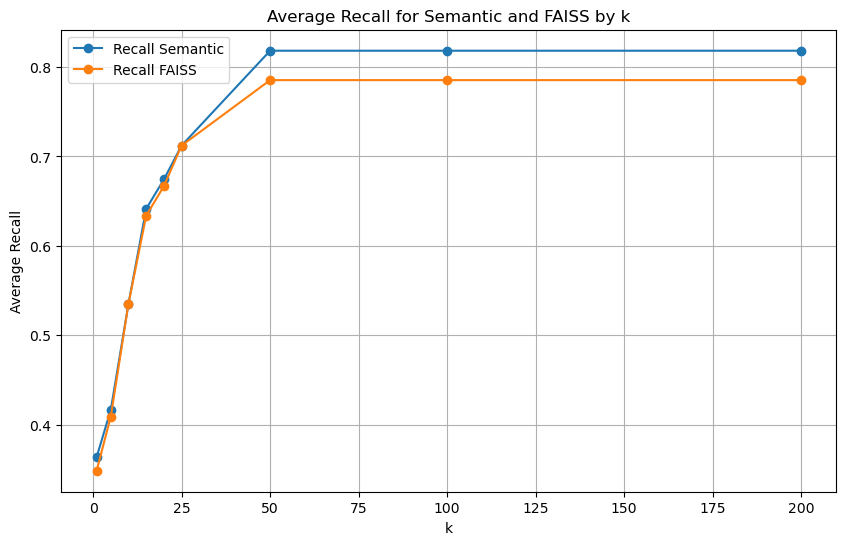

In [ ]:
plot_average_recall(results_for_query)

## MRR

In [33]:
def get_correct_positions(correct, predicted):

    positions = []
    for idx, item in enumerate(predicted):
        if item in correct:
            positions.append(idx)
    return positions

def get_correct_positions_without_duplicates(correct, predicted):

    unique_predicted = []
    for item in predicted:
        if item not in unique_predicted:
            unique_predicted.append(item)

    positions = []
    for idx, item in enumerate(unique_predicted):
        if item in correct:
            positions.append(idx+1)
    return positions

def get_answers( query, model, top_k=200, answer_embeddings = answer_embeddings_np, answer_texts=answers, hf_dataset= hf_dataset, correct_answers_dict=complete_dict, is_faiss_automatic = True):
    query_embedding = model.encode([query], convert_to_tensor=True)
    cosine_scores = cosine_similarity(query_embedding.cpu().numpy(), answer_embeddings)
    top_k_indices = np.argsort(cosine_scores[0])[-top_k:][::-1]

    semantic_search = [answer_texts[i] for i in top_k_indices]

    if is_faiss_automatic:
        scores, examples = hf_dataset.get_nearest_examples(
            index_name="answer_embedding",
            query=query_embedding.cpu().numpy(),
            k=top_k
        )

        faiss_search = examples['answer']
    else:
        faiss_search = faiss_search_manual(query, answer_embeddings, answer_texts, model, top_k)

    correct_answers = complete_dict[query]

    return semantic_search, faiss_search, correct_answers,


def calculate_MRR(actual_relevant):
    Q = len(actual_relevant)
    cumulative_reciprocal = 0
    for i in range(Q):
        if(len(actual_relevant[i]) == 0):
            reciprocal = 0
        else:
            first_result = actual_relevant[i][0]
            reciprocal = 1 / first_result
        cumulative_reciprocal += reciprocal
        print(f"query #{i+1} = 1/{first_result} = {reciprocal}")

    mrr = 1/Q * cumulative_reciprocal

    print("MRR =", round(mrr,2))

    return mrr

In [35]:
random.seed(42)
queries = random.sample(list(complete_dict.keys()), 400)

In [36]:
actual_relevant_semantic = []
actual_relevant_faiss = []

for query in queries:
    semantic_search, faiss_search, correct_answers = get_answers(query, model)
    single_query_result_semantic = get_correct_positions_without_duplicates(correct_answers, semantic_search )
    single_query_result_faiss = get_correct_positions_without_duplicates(correct_answers, faiss_search )
    actual_relevant_semantic.append(single_query_result_semantic)
    actual_relevant_faiss.append(single_query_result_faiss)

query #1 = 1/1 = 1.0
query #2 = 1/1 = 1.0
query #3 = 1/3 = 0.3333333333333333
query #4 = 1/1 = 1.0
query #5 = 1/1 = 1.0
query #6 = 1/7 = 0.14285714285714285
query #7 = 1/1 = 1.0
query #8 = 1/1 = 1.0
query #9 = 1/1 = 1.0
query #10 = 1/1 = 1.0
query #11 = 1/2 = 0.5
query #12 = 1/1 = 1.0
query #13 = 1/1 = 1.0
query #14 = 1/1 = 1.0
query #15 = 1/1 = 1.0
query #16 = 1/1 = 1.0
query #17 = 1/1 = 1.0
query #18 = 1/2 = 0.5
query #19 = 1/1 = 1.0
query #20 = 1/1 = 1.0
query #21 = 1/1 = 1.0
query #22 = 1/1 = 1.0
query #23 = 1/1 = 1.0
query #24 = 1/1 = 1.0
query #25 = 1/1 = 1.0
query #26 = 1/4 = 0.25
query #27 = 1/1 = 1.0
query #28 = 1/1 = 1.0
query #29 = 1/1 = 1.0
query #30 = 1/1 = 1.0
query #31 = 1/1 = 1.0
query #32 = 1/1 = 1.0
query #33 = 1/1 = 1.0
query #34 = 1/2 = 0.5
query #35 = 1/1 = 1.0
query #36 = 1/2 = 0.5
query #37 = 1/4 = 0.25
query #38 = 1/1 = 1.0
query #39 = 1/1 = 1.0
query #40 = 1/8 = 0.125
query #41 = 1/1 = 1.0
query #42 = 1/1 = 1.0
query #43 = 1/2 = 0.5
query #44 = 1/1 = 1.0
query 

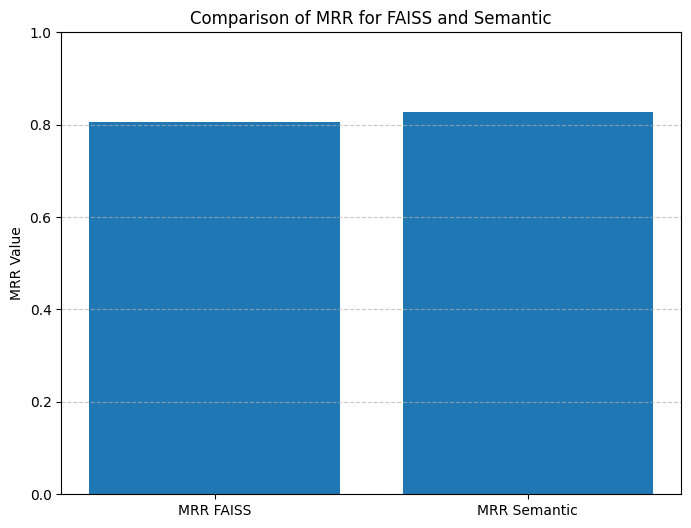

In [37]:
mrr_faiss = calculate_MRR(actual_relevant_faiss)
mrr_semantic = calculate_MRR(actual_relevant_semantic)


labels = ['MRR FAISS', 'MRR Semantic']
values = [mrr_faiss, mrr_semantic]

plt.figure(figsize=(8, 6))
plt.bar(labels, values)
plt.ylim(0, 1)
plt.ylabel('MRR Value')
plt.title('Comparison of MRR for FAISS and Semantic')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# MANUAL FAISS

In [ ]:
k_values = [1, 5, 10, 15, 20, 25, 50, 100, 200]
results_for_query = {}

for query in all_question:
    results = calculate_and_visualize_recall(query, k_values, model, False, is_faiss_automatic=False)
    results_for_query[query] = results

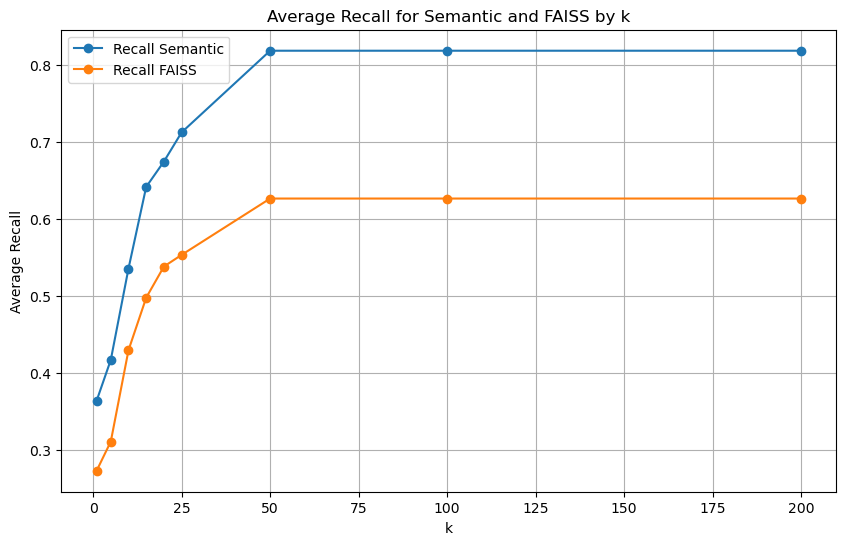

In [ ]:
plot_average_recall(results_for_query)

In [ ]:
actual_relevant_semantic = []
actual_relevant_faiss = []

for query in queries:
    semantic_search, faiss_search, correct_answers = get_answers(query, model, is_faiss_automatic=False)
    single_query_result_semantic = get_correct_positions_without_duplicates(correct_answers, semantic_search )
    single_query_result_faiss = get_correct_positions_without_duplicates(correct_answers, faiss_search )
    actual_relevant_semantic.append(single_query_result_semantic)
    actual_relevant_faiss.append(single_query_result_faiss)

query #1 = 1/2 = 0.5
query #2 = 1/1 = 1.0
query #3 = 1/1 = 1.0
query #4 = 1/2 = 0.5
query #5 = 1/2 = 0
query #6 = 1/1 = 1.0
query #7 = 1/1 = 1.0
query #8 = 1/1 = 1.0
query #9 = 1/1 = 1.0
query #10 = 1/1 = 0
query #11 = 1/1 = 0
query #12 = 1/1 = 1.0
query #13 = 1/9 = 0.1111111111111111
query #14 = 1/1 = 1.0
query #15 = 1/1 = 0
query #16 = 1/1 = 0
query #17 = 1/1 = 1.0
query #18 = 1/1 = 1.0
query #19 = 1/1 = 1.0
query #20 = 1/11 = 0.09090909090909091
query #21 = 1/11 = 0
query #22 = 1/2 = 0.5
query #23 = 1/2 = 0
query #24 = 1/1 = 1.0
query #25 = 1/1 = 1.0
query #26 = 1/1 = 0
query #27 = 1/1 = 1.0
query #28 = 1/1 = 1.0
query #29 = 1/1 = 1.0
query #30 = 1/1 = 1.0
query #31 = 1/3 = 0.3333333333333333
query #32 = 1/1 = 1.0
query #33 = 1/2 = 0.5
query #34 = 1/2 = 0
query #35 = 1/2 = 0.5
query #36 = 1/1 = 1.0
query #37 = 1/1 = 1.0
query #38 = 1/1 = 1.0
query #39 = 1/1 = 0
query #40 = 1/2 = 0.5
query #41 = 1/1 = 1.0
query #42 = 1/1 = 1.0
query #43 = 1/1 = 1.0
query #44 = 1/1 = 0
query #45 = 1/2

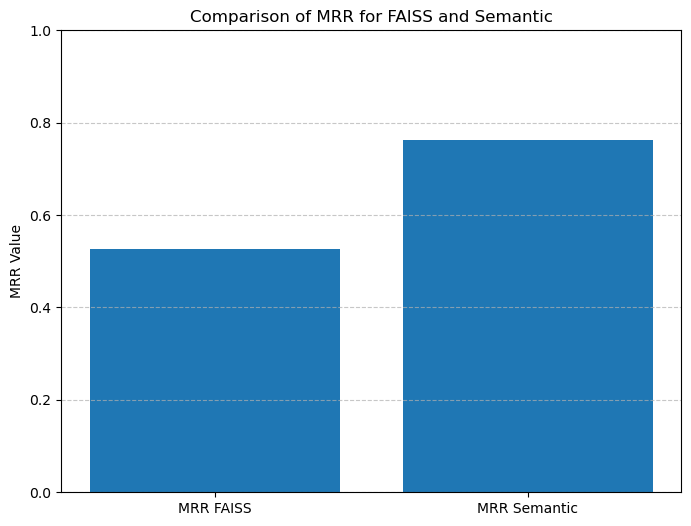

In [ ]:
mrr_faiss = calculate_MRR(actual_relevant_faiss)
mrr_semantic = calculate_MRR(actual_relevant_semantic)


labels = ['MRR FAISS', 'MRR Semantic']
values = [mrr_faiss, mrr_semantic]

plt.figure(figsize=(8, 6))
plt.bar(labels, values)
plt.ylim(0, 1)
plt.ylabel('MRR Value')
plt.title('Comparison of MRR for FAISS and Semantic')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Różnica czasu

In [ ]:
import time

def measure_search_times(questions, model, top_k=5, answer_embeddings=answer_embeddings_np, answer_texts=answers, hf_dataset=hf_dataset, is_faiss_automatic=True):
    times = []

    for query in questions:
        query_embedding = model.encode([query], convert_to_tensor=True)

        # Semantic search timing
        start_semantic = time.time()
        cosine_scores = cosine_similarity(query_embedding.cpu().numpy(), answer_embeddings)
        top_k_indices = np.argsort(cosine_scores[0])[-top_k:][::-1]
        semantic_search = [answer_texts[i] for i in top_k_indices]
        time_semantic = time.time() - start_semantic

        # FAISS search timing
        start_faiss = time.time()
        if is_faiss_automatic:  # Automatic FAISS search
            scores, examples = hf_dataset.get_nearest_examples(
                index_name="answer_embedding",
                query=query_embedding.cpu().numpy(),
                k=top_k
            )
            faiss_search = examples['answer']
        else:
            faiss_search = faiss_search_manual(query, answer_embeddings, answer_texts, model, top_k)
        time_faiss = time.time() - start_faiss

        # Append results
        times.append({"query": query, "time_semantic": time_semantic, "time_faiss": time_faiss})

    return times


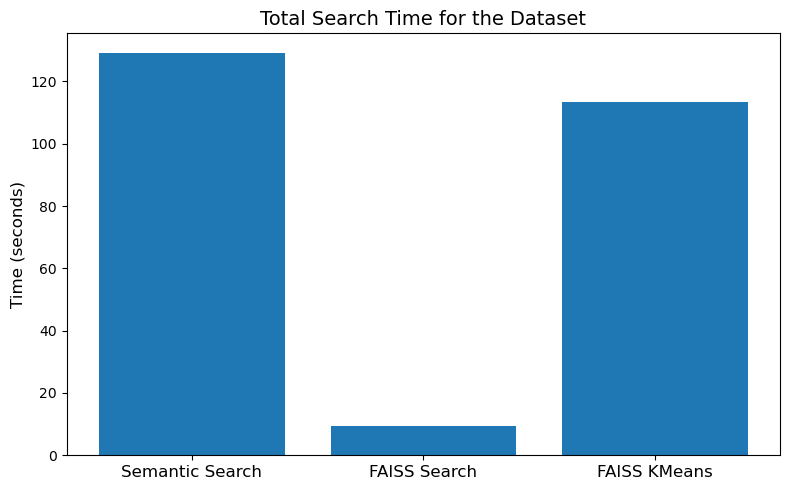

In [ ]:
result = measure_search_times(queries, model)
result_kmeans =  measure_search_times(queries, model, is_faiss_automatic=False)

semantic_times = [r["time_semantic"] for r in result]
faiss_times = [r["time_faiss"] for r in result]
kmeans_times = [r["time_faiss"] for r in result_kmeans]


total_semantic_time = sum(semantic_times)
total_faiss_time = sum(faiss_times)
total_kmeans = sum(kmeans_times)

methods = ['Semantic Search', 'FAISS Search', 'FAISS KMeans']
total_times = [total_semantic_time, total_faiss_time, total_kmeans]

plt.figure(figsize=(8, 5))
plt.bar(methods, total_times)


plt.title("Total Search Time for the Dataset", fontsize=14)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xticks(fontsize=12)

# Wyświetlenie wykresu
plt.tight_layout()
plt.show()


# Reranker

In [17]:
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
import numpy as np
from datasets import Dataset
import pandas as pd
import re
import matplotlib.pyplot as plt

from prettytable import PrettyTable
from sklearn.metrics.pairwise import cosine_similarity
import random
import faiss
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [40]:
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

In [197]:
reranker_model = AutoModelForSequenceClassification.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")
reranker_tokenizer = AutoTokenizer.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")

reranker_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-1

# Dane - liczenie od nowa

In [ ]:
# dataset = load_dataset("sentence-transformers/squad")
# questions = dataset['train']['question']
# answers = dataset['train']['answer']

# question_embeddings = model.encode(questions, convert_to_tensor=True, show_progress_bar=True)
# answer_embeddings = model.encode(answers, convert_to_tensor=True, show_progress_bar=True)

# question_embeddings_np = question_embeddings.cpu().numpy()
# answer_embeddings_np = answer_embeddings.cpu().numpy()
# data = {
#     "question": questions,
#     "answer": answers,
#     "question_embedding": list(question_embeddings_np),
#     "answer_embedding": list(answer_embeddings_np)
# }

# df = pd.DataFrame(data)


# df_dataset = Dataset.from_pandas(df)
# df_dataset = df_dataset.add_faiss_index(column="answer_embedding")

# questions = df['question'].to_list()
# answers = df['answer'].to_list()
# question_embeddings_np = list(question_embeddings_np)
# answer_embeddings_np = list(answer_embeddings_np)


# Dane z csv

In [198]:
def fix_and_convert_to_array(embedding_str):

    fixed_str = re.sub(r'(\d)(\s)(-?\d)', r'\1,\3', embedding_str.strip())
    fixed_str = fixed_str.replace('[', '').replace(']', '')
    fixed_list = list(map(float, fixed_str.split(',')))
    return np.array(fixed_list)


df = pd.read_csv('embeddings_zad3.csv')

df['question_embedding'] = df['question_embedding'].apply(fix_and_convert_to_array)
df['answer_embedding'] = df['answer_embedding'].apply(fix_and_convert_to_array)



df_dataset = Dataset.from_pandas(df)
df_dataset = df_dataset.add_faiss_index(column="answer_embedding")

questions = df['question'].to_list()
answers = df['answer'].to_list()
question_embeddings_np = np.vstack(df['question_embedding'].to_numpy())
answer_embeddings_np = np.vstack(df['answer_embedding'].to_numpy())

  0%|          | 0/1 [00:00<?, ?it/s]

# Funkcje do  wyszukiwania

In [199]:
def fun_semantic_search(query, model=model, answer_embedding=answer_embeddings_np, answer_texts=answers, top_k=200):
    query_embedding = model.encode([query], convert_to_tensor=True)
    cosine_scores = cosine_similarity(
        query_embedding.cpu().numpy(), answer_embedding
    )
    top_k_indices = np.argsort(cosine_scores[0])[-top_k:][::-1]
    return [answer_texts[i] for i in top_k_indices]

In [211]:
def faiss_search_with_df(query, hf_dataset=df_dataset, model=model, top_k=200, index_name="answer", index_embedding_name="answer_embedding"):

    query_embedding = model.encode(query, convert_to_tensor=True).cpu().numpy()

    scores, examples = hf_dataset.get_nearest_examples(
        index_name=index_embedding_name,
        query=query_embedding,  # Single query embedding
        k=top_k
    )

    return list(examples[index_name])

In [202]:
def search_with_reranker(model, tokenizer, query, answers, top_k=3):
    scores = []
    for candidate in answers:
        inputs = tokenizer(query, candidate, return_tensors="pt", truncation=True, padding=True)

        with torch.no_grad():
            logits = model(**inputs).logits
            score = logits.item()
            scores.append(score)

    ranked_results = sorted(zip(answers, scores), key=lambda x: x[1], reverse=True)

    top_results = ranked_results[:top_k]

    return [result[0] for result in top_results]

# metryki

In [24]:
def calculate_recall(actual, predicted, k):

    if isinstance(actual, str):
        actual = [actual]

    act_set = set(actual)
    pred_set = set(predicted[:k])

    result = round(len(act_set & pred_set) / float(len(act_set)), 2)
    return result

In [46]:
def get_correct_positions_without_duplicates(correct, predicted):

    unique_predicted = []
    for item in predicted:
        if item not in unique_predicted:
            unique_predicted.append(item)

    positions = []
    for idx, item in enumerate(unique_predicted):
        if item in correct:
            positions.append(idx+1)
    return positions

In [47]:
def calculate_MRR(actual_relevant):
    Q = len(actual_relevant)
    cumulative_reciprocal = 0
    for i in range(Q):
        if(len(actual_relevant[i]) == 0):
            reciprocal = 0
            print(f"query #{i+1} = {reciprocal}")
        else:
            first_result = actual_relevant[i][0]
            reciprocal = 1 / first_result
            print(f"query #{i+1} = 1/{first_result} = {reciprocal}")
        cumulative_reciprocal += reciprocal

    mrr = 1/Q * cumulative_reciprocal

    print("MRR =", round(mrr,2))

    return mrr

# dobre odpowiedzi

In [203]:
question_answer_dict = df.drop_duplicates(subset=['question', 'answer']).set_index('question')['answer'].to_dict()
duplicated_questions = df[df.duplicated(subset='question', keep=False)]
duplicated_question_answer_dict = duplicated_questions.groupby('question')['answer'].apply(list).to_dict()
duplicated_question_unique_answer = {
    question: answers for question, answers in duplicated_question_answer_dict.items() if len(answers) == len(set(answers))
}
complete_dict = question_answer_dict | duplicated_question_answer_dict

In [ ]:
# random.seed(42)
# queries = random.sample(list(complete_dict.keys()), 500)

# Odpowiedzi

In [204]:
def generate_tables(query, semantic_results, faiss_results, reranker_results, reranker_faiss_results, correct_answers):
    def format_table(header, rows):
        table = f"{header[0]:<40} | {header[1]:<20}\n"
        table += "-" * 65 + "\n"
        for row in rows:
            table += f"{row[0]:<40} | {row[1]:<20}\n"
        return table

    semantic_rows = [(query, result) for result in semantic_results]
    faiss_rows = [(query, result) for result in faiss_results]
    reranker_rows = [(query, result) for result in reranker_results]
    reranker_faiss_rows = [(query, result) for result in reranker_faiss_results]
    correct_rows = [(query, answer) for answer in correct_answers]

    semantic_table = format_table(["Query", "Semantic Result"], semantic_rows)
    faiss_table = format_table(["Query", "FAISS Result"], faiss_rows)
    reranker_table = format_table(["Query", "Reranker Result"], reranker_rows)
    reranker_faiss_table = format_table(["Query", "Reranker FAISS Result"], reranker_faiss_rows)
    correct_table = format_table(["Query", "Correct Answer"], correct_rows)

    print("Semantic Search Results:")
    print(semantic_table)
    print("\nFAISS Search Results:")
    print(faiss_table)
    print("\nReranker Search Results:")
    print(reranker_table)
    print("\nReranker FAISS Search Results:")
    print(reranker_faiss_table)
    print("\nCorrect Answers:")
    print(correct_table)

In [205]:
def pipline(queries, model=model, top_k=30, answer_embeddings=answer_embeddings_np, answer_texts=answers, hf_dataset=df_dataset, index_name="answer", index_embedding_name="answer_embedding",
            reranker_model=reranker_model, reranker_tokenizer=reranker_tokenizer, correct_answers_dict=complete_dict, visualize=True):

    correct_answers = []
    semantic_results = []
    faiss_results = []
    reranker_results = []
    reranker_faiss_results = []

    for query in queries:
        if correct_answers_dict.get(query) is not None:
            correct_answer = correct_answers_dict[query]
            correct_answers.append(correct_answer)

        semantic_result = fun_semantic_search(query, top_k=top_k, answer_embedding=answer_embeddings, answer_texts=answer_texts)
        faiss_result = faiss_search_with_df(query, hf_dataset, model, top_k, index_name, index_embedding_name)
        reranker_result = search_with_reranker(reranker_model, reranker_tokenizer, query, semantic_result, top_k)
        reranker_faiss_result = search_with_reranker(reranker_model, reranker_tokenizer, query, faiss_result, top_k)

        semantic_results.append(semantic_result)
        faiss_results.append(faiss_result)
        reranker_results.append(reranker_result)
        reranker_faiss_results.append(reranker_faiss_result)

        if visualize:
            generate_tables(query, semantic_result, faiss_result, reranker_result, reranker_faiss_result, correct_answer)

    return correct_answers, semantic_results, faiss_results, reranker_results, reranker_faiss_results

In [ ]:
random.seed(42)
queries = random.sample(list(duplicated_question_unique_answer.keys()), 6)
queries

['What does CD stand for?',
 'How could a white child be considered a member of the Omaha tribe?',
 'What was the per capita income for the city?',
 'What does DRM stand for?',
 'Who wrote the Divine Comedy?',
 'In what year did Chopin become a French citizen?']

In [ ]:
correct_answers, semantic_results, faiss_results, reranker_results, reranker_faiss_results = pipline(queries, top_k=100)

Semantic Search Results:
Query                                    | Semantic Result     
-----------------------------------------------------------------
What does CD stand for?                  | Compact Disc (CD) is a digital optical disc data storage format. The format was originally developed to store and play only sound recordings but was later adapted for storage of data (CD-ROM). Several other formats were further derived from these, including write-once audio and data storage (CD-R), rewritable media (CD-RW), Video Compact Disc (VCD), Super Video Compact Disc (SVCD), Photo CD, PictureCD, CD-i, and Enhanced Music CD. Audio CDs and audio CD players have been commercially available since October 1982.
What does CD stand for?                  | Compact Disc (CD) is a digital optical disc data storage format. The format was originally developed to store and play only sound recordings but was later adapted for storage of data (CD-ROM). Several other formats were further derived from

# Recall

In [ ]:
def calculate_recall(actual, predicted, k):

    if isinstance(actual, str):
        actual = [actual]

    act_set = set(actual)
    pred_set = set(predicted[:k])

    result = round(len(act_set & pred_set) / float(len(act_set)), 2)
    return result

In [ ]:
def calculate_metric(metric, semantic_search, faiss_search, reranker_search, reranker_faiss_search, correct_answers, k):
    if metric == 'recall':
        recall_semantic = calculate_recall( correct_answers, semantic_search, k)

        recall_faiss = calculate_recall(correct_answers, faiss_search, k)

        recall_reranker = calculate_recall(correct_answers, reranker_search, k)

        recall_reranker_faiss = calculate_recall(correct_answers, reranker_faiss_search, k)

        return [recall_semantic, recall_faiss, recall_reranker, recall_reranker_faiss]

In [ ]:
def calculate_and_visualize_recall(semantic_search, faiss_search, reranker_search, reranker_faiss_search, correct_answers, k_values, idx, visualise=True):
    recall_values_dict = {}

    for k in k_values:
        result = calculate_metric('recall', semantic_search[idx], faiss_search[idx], reranker_search[idx], reranker_faiss_search[idx], correct_answers[idx], k)
        recall_values_dict[k] = result

    semantic_recall = [recall_values_dict[k][0] for k in k_values]
    faiss_recall = [recall_values_dict[k][1] for k in k_values]
    reranker_recall = [recall_values_dict[k][2] for k in k_values]
    reranker_faiss_recall = [recall_values_dict[k][3] for k in k_values]


    if visualise:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

        # Semantic Search vs FAISS
        axes[0].plot(k_values, semantic_recall, marker='o', label='Semantic Search Recall')
        axes[0].plot(k_values, faiss_recall, marker='s', label='FAISS Recall')
        axes[0].set_title('Recall: Semantic Search vs FAISS')
        axes[0].set_xlabel('k-values')
        axes[0].set_ylabel('Recall')
        axes[0].legend()
        axes[0].grid(True)

        # Reranker vs Reranker FAISS
        axes[1].plot(k_values, reranker_recall, marker='x', label='Reranker Recall', color='green')
        axes[1].plot(k_values, reranker_faiss_recall, marker='d', label='Reranker FAISS Recall', color='pink')
        axes[1].set_title('Recall: Reranker vs Reranker FAISS')
        axes[1].set_xlabel('k-values')
        axes[1].legend()
        axes[1].grid(True)

        # plt.figure(figsize=(10, 6))
        # plt.plot(k_values, semantic_recall, marker='o', label='Semantic Search Recall')
        # plt.plot(k_values, faiss_recall, marker='s', label='FAISS Recall')
        # plt.plot(k_values, reranker_recall, marker='x', label='Reranker Recall')
        # plt.plot(k_values, reranker_faiss_recall, marker='d', label='Reranker FAISS Recall')

        # plt.title('Recall Values for Semantic Search, FAISS and Reranker')
        # plt.xlabel('k-values')
        # plt.ylabel('Recall')
        # plt.legend()
        # plt.grid(True)
        # plt.show()

    return recall_values_dict

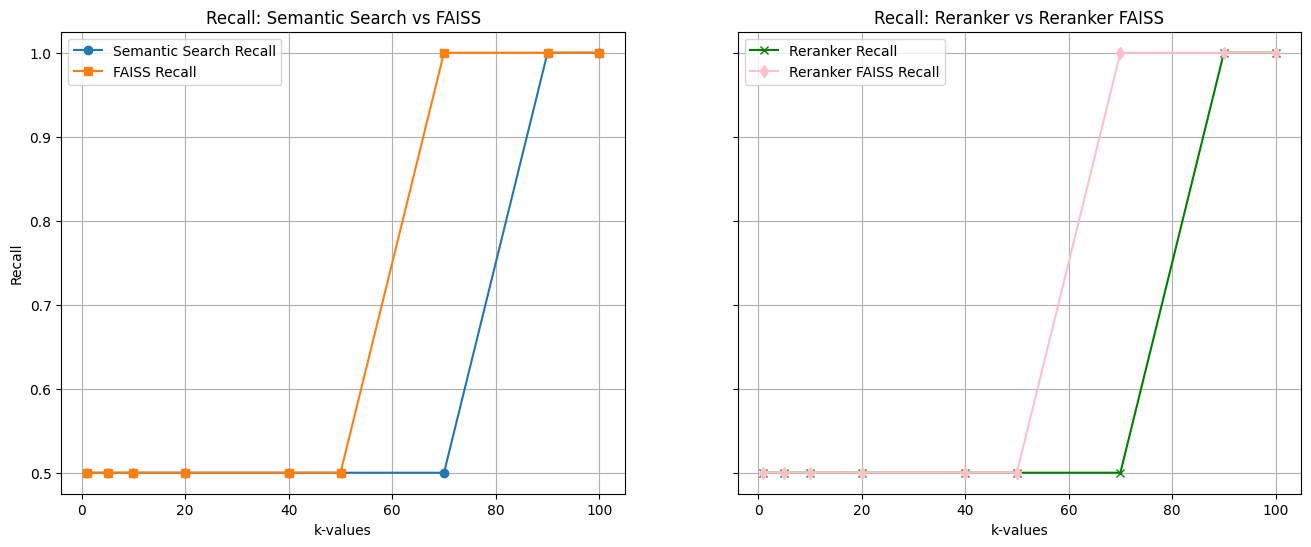

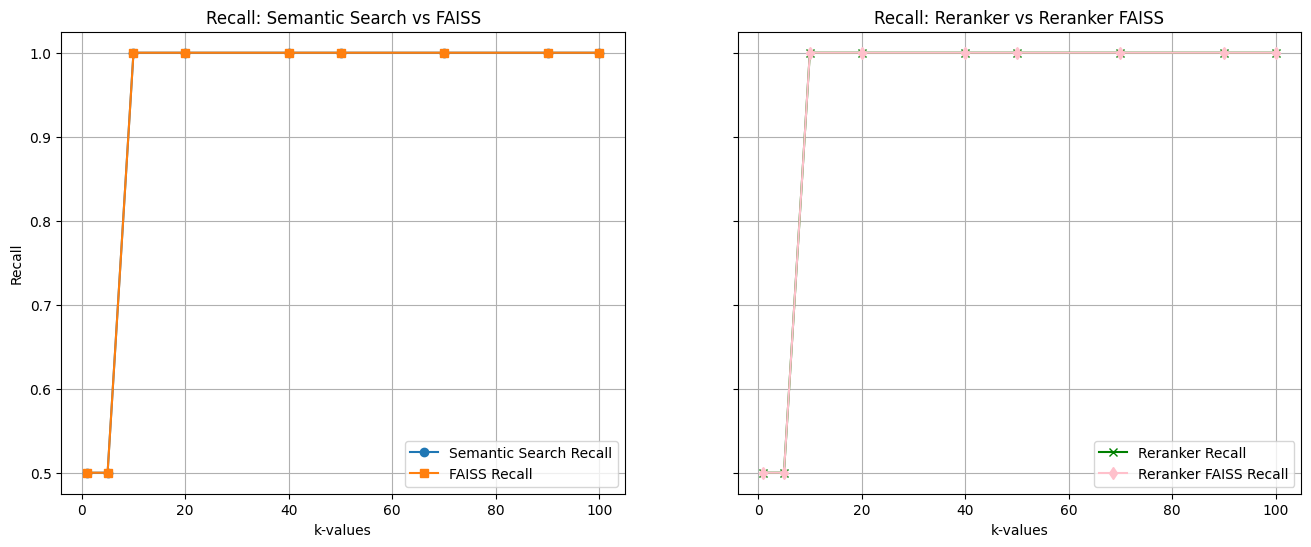

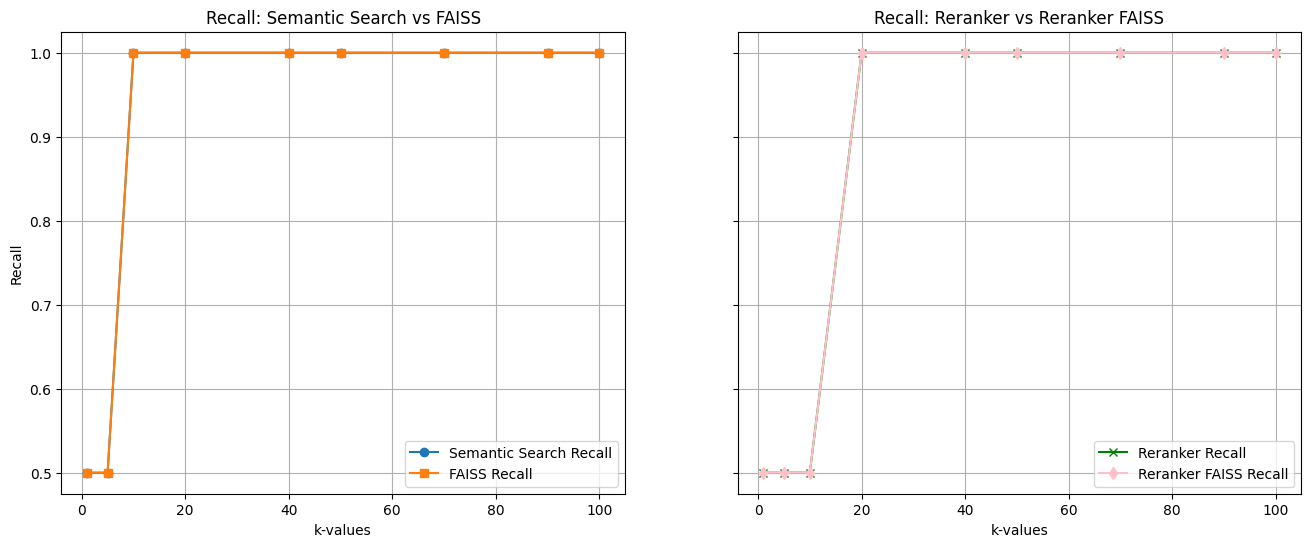

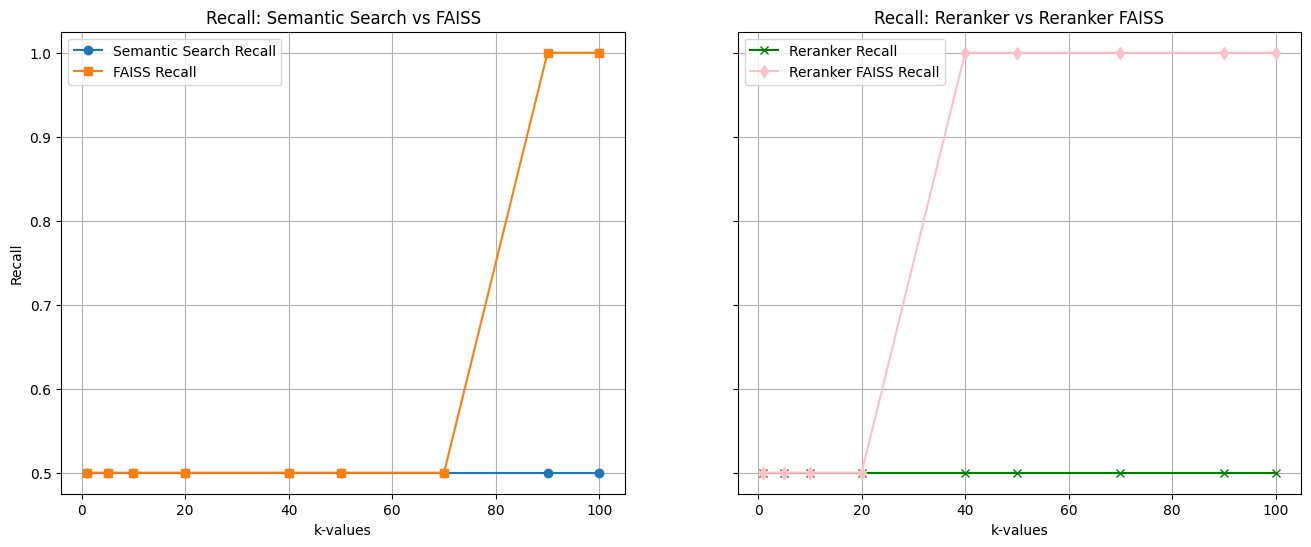

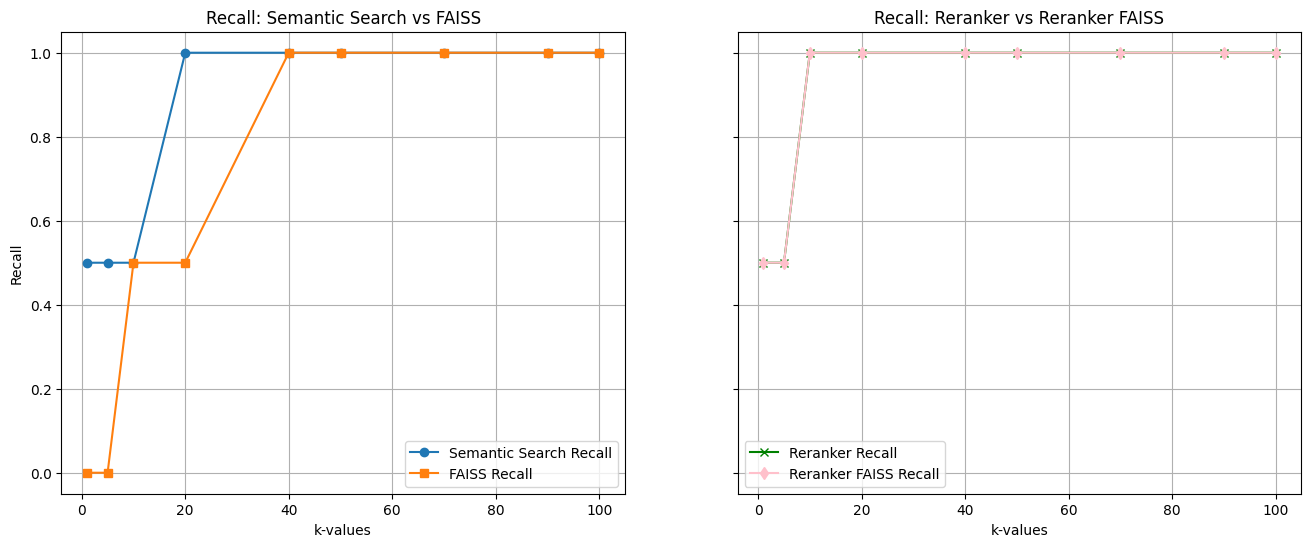

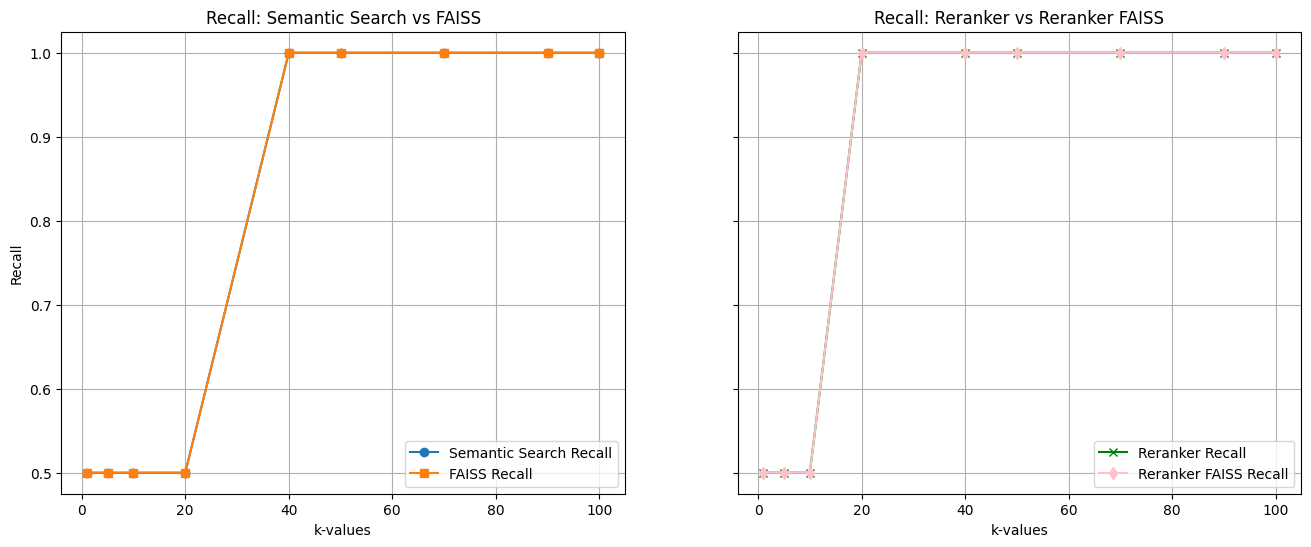

In [ ]:
k_values = [1, 5, 10, 20, 40,  50, 70, 90, 100]

for idx, query in enumerate(queries):
    calculate_and_visualize_recall(semantic_results, faiss_results, reranker_results, reranker_faiss_results, correct_answers, k_values, idx)

## Średni recall dla wszystkich pytań

In [ ]:
def plot_average_recall(results_for_query):

    data = []

    for query, results in results_for_query.items():
        for k, values in results.items():
            data.append({"Query": query, "k": k, "Recall_Semantic": values[0], "Recall_FAISS": values[1], 'Recall_Reranker': values[2], 'Recall_Reranker_FAISS': values[3]})

    df = pd.DataFrame(data)

    average_results = df.groupby("k")[["Recall_Semantic", "Recall_FAISS", "Recall_Reranker", "Recall_Reranker_FAISS"]].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(average_results.index, average_results["Recall_Semantic"], label="Recall Semantic", marker="o")
    plt.plot(average_results.index, average_results["Recall_FAISS"], label="Recall FAISS", marker="o", alpha=0.9)
    plt.plot(average_results.index, average_results["Recall_Reranker"], label="Recall Reranker", marker="o", alpha=0.7)
    plt.plot(average_results.index, average_results["Recall_Reranker_FAISS"], label="Recall Reranker FAISS", marker="o", alpha=0.5)

    plt.title("Average Recall for Semantic, FAISS, Reranker and Reranker FAISS by k")
    plt.xlabel("k")
    plt.ylabel("Average Recall")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
all_question = list(duplicated_question_unique_answer.keys())
len((all_question))

66

In [ ]:
correct_answers_all, semantic_results_all, faiss_results_all, reranker_results_all, reranker_faiss_results_all = pipline(all_question, top_k=100, visualize=False)

In [ ]:
results_for_query = {}

for idx, query in enumerate(all_question):
    results = calculate_and_visualize_recall(semantic_results_all, faiss_results_all, reranker_results_all, reranker_faiss_results_all, correct_answers_all, k_values, idx, visualise=False)
    results_for_query[query] = results

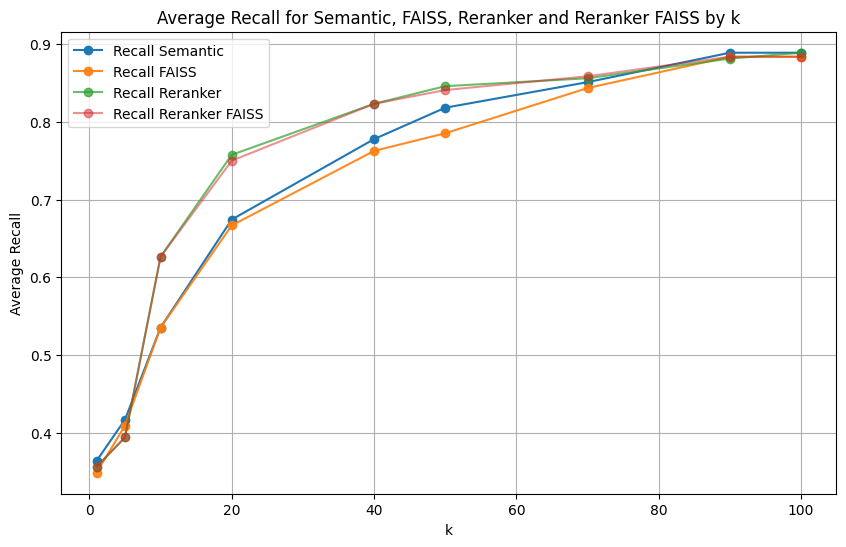

In [ ]:
plot_average_recall(results_for_query)

# MRR

In [ ]:
random.seed(42)
queries = random.sample(list(complete_dict.keys()), 50)

In [ ]:
correct_answers_mrr, semantic_results_mrr, faiss_results_mrr, reranker_results_mrr, reranker_faiss_results_mrr = pipline(queries, top_k=100, visualize=False)

In [ ]:
actual_relevant_semantic = []
actual_relevant_faiss = []
actual_relevant_reranker = []
actual_relevant_reranker_faiss = []

for idx, query in enumerate(queries):
    semantic_search, faiss_search, reranker_search, reranker_faiss_search, correct_answers = semantic_results_mrr[idx], faiss_results_mrr[idx], reranker_results_mrr[idx], reranker_faiss_results_mrr[idx], complete_dict[query]
    single_query_result_semantic = get_correct_positions_without_duplicates(correct_answers, semantic_search )
    single_query_result_faiss = get_correct_positions_without_duplicates(correct_answers, faiss_search )
    single_query_result_reranker = get_correct_positions_without_duplicates(correct_answers, reranker_search )
    single_query_result_reranker_faiss = get_correct_positions_without_duplicates(correct_answers, reranker_faiss_search )
    actual_relevant_semantic.append(single_query_result_semantic)
    actual_relevant_faiss.append(single_query_result_faiss)
    actual_relevant_reranker.append(single_query_result_reranker)
    actual_relevant_reranker_faiss.append(single_query_result_reranker_faiss)

In [ ]:
mrr_semantic = calculate_MRR(actual_relevant_semantic)
mrr_faiss = calculate_MRR(actual_relevant_faiss)
mrr_reranker = calculate_MRR(actual_relevant_reranker)
mrr_reranker_faiss = calculate_MRR(actual_relevant_reranker_faiss)

query #1 = 1/1 = 1.0
query #2 = 1/1 = 1.0
query #3 = 1/1 = 1.0
query #4 = 1/1 = 1.0
query #5 = 1/4 = 0.25
query #6 = 1/1 = 1.0
query #7 = 1/1 = 1.0
query #8 = 1/1 = 1.0
query #9 = 1/1 = 1.0
query #10 = 1/1 = 1.0
query #11 = 1/1 = 1.0
query #12 = 1/1 = 1.0
query #13 = 1/13 = 0.07692307692307693
query #14 = 1/1 = 1.0
query #15 = 1/1 = 1.0
query #16 = 1/3 = 0.3333333333333333
query #17 = 1/1 = 1.0
query #18 = 1/1 = 1.0
query #19 = 1/1 = 1.0
query #20 = 1/13 = 0.07692307692307693
query #21 = 1/1 = 1.0
query #22 = 1/4 = 0.25
query #23 = 1/2 = 0.5
query #24 = 1/1 = 1.0
query #25 = 1/1 = 1.0
query #26 = 1/1 = 1.0
query #27 = 1/1 = 1.0
query #28 = 1/1 = 1.0
query #29 = 1/1 = 1.0
query #30 = 1/1 = 1.0
query #31 = 1/2 = 0.5
query #32 = 1/1 = 1.0
query #33 = 1/3 = 0.3333333333333333
query #34 = 1/3 = 0.3333333333333333
query #35 = 1/2 = 0.5
query #36 = 1/1 = 1.0
query #37 = 1/1 = 1.0
query #38 = 1/2 = 0.5
query #39 = 1/1 = 1.0
query #40 = 1/2 = 0.5
query #41 = 1/1 = 1.0
query #42 = 1/1 = 1.0
quer

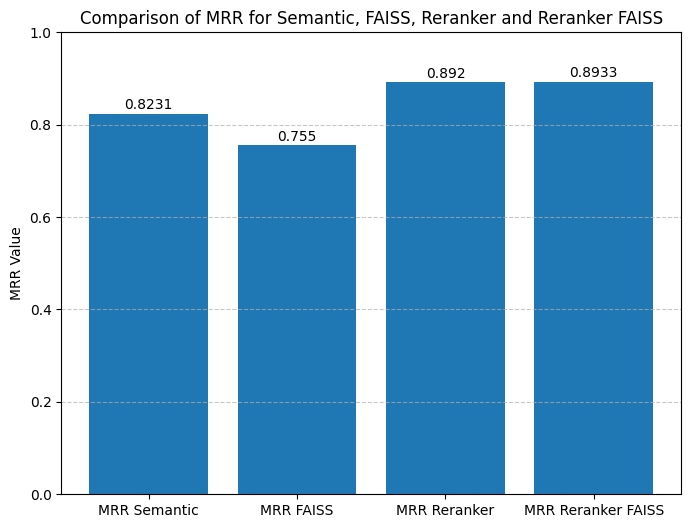

In [ ]:
labels = ['MRR Semantic', 'MRR FAISS', 'MRR Reranker', 'MRR Reranker FAISS']
values = [mrr_semantic, mrr_faiss, mrr_reranker, mrr_reranker_faiss]

plt.figure(figsize=(8, 6))
plt.bar(labels, values)
for i, value in enumerate(values):
    plt.text(i, value + 0.01, str(round(value, 4)), ha='center', fontsize=10)

plt.ylim(0, 1)
plt.ylabel('MRR Value')
plt.title('Comparison of MRR for Semantic, FAISS, Reranker and Reranker FAISS')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## RAG

In [ ]:
pip install -U langchain-community

In [ ]:
!pip install langchain_openai

In [33]:
import langchain
from langchain.document_loaders import DirectoryLoader
from langchain.prompts import ChatPromptTemplate

In [34]:
openai_api_key = "uiXn64-EBi__XOmb9n0W4xExkcT_iZBxFGhhHcsHKQ5YLrOs"
openai_api_base = "https://services.clarin-pl.eu/api/v1/oapi"

In [187]:
PROMPT_TEMPLATE = """
{context}

---

Answer the question based on the above context: {question}
"""

PROMPT_RANKING_TEMPLATE = """
Provided a ranked context:

{context}

---

Evaluate which context answers the questions best: {question}
"""


In [188]:
def retrieve(query: str, method: str, documents):
  if documents == 'alice':
    _, semantic_results_mrr, faiss_results_mrr, reranker_results_mrr, reranker_faiss_results_mrr = pipline([query], top_k=3, answer_embeddings=alice_embeddings_np, answer_texts=chunks, hf_dataset=df_dataset, index_name="chunks", index_embedding_name="alice_embedding",
            correct_answers_dict={}, visualize=False)
  else:
    correct_answers_mrr, semantic_results_mrr, faiss_results_mrr, reranker_results_mrr, reranker_faiss_results_mrr = pipline([query], top_k=3, visualize=False)
  if method == 'faiss':
    return faiss_results_mrr
  elif method == 'reranker':
    ranking = ""
    for i, rank in enumerate(reranker_faiss_results_mrr[0]):
      ranking += f"{i}. : {rank}\n"
    return ranking
  else:
    return semantic_results_mrr

In [191]:
def create_prompt(context_text, query_text, method):
  if method == 'reranker':
    prompt_template = ChatPromptTemplate.from_template(PROMPT_RANKING_TEMPLATE)
  else:
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
  prompt = prompt_template.format(context=context_text, question=query_text)

  return prompt


In [38]:
%%capture
!pip install openai==1.55.3 httpx==0.27.2 --force-reinstall --quiet


In [39]:
from langchain.chat_models import ChatOpenAI

client = ChatOpenAI(openai_api_key=openai_api_key, openai_api_base=openai_api_base, model="llama")


<ipython-input-39-f04a4d634f34>:3: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  client = ChatOpenAI(openai_api_key=openai_api_key, openai_api_base=openai_api_base, model="llama")


In [209]:
def generate_response_with_rag(query, method, documents=""):
  context_text = retrieve(query, method, documents)
  prompt = create_prompt(context_text, query, method)
  response = client.invoke(prompt)
  formatted_response = f"Response: {response.content}"
  return formatted_response

def generate_response(query):
  response = client.invoke(query)
  formatted_response = f"Response: {response.content}"
  return formatted_response

In [81]:
import textwrap
def print_response(response):
  print(textwrap.fill(response, width=80))

### SQUAD

In [213]:
query = "What was the name of Beyoncé's second solo album?"

print(query)
print("\nLLAMA 3.1")
print_response(generate_response(query))

print("\nLLAMA 3.1 with RAG (semantic)")
print_response(generate_response_with_rag(query, 'semantic'))

print("\nLLAMA 3.1 with RAG (FAISS)")
print_response(generate_response_with_rag(query, 'faiss'))

print("\nLLAMA 3.1 with RAG (RERANKER)")
print_response(generate_response_with_rag(query, 'reranker'))


What was the name of Beyoncé's second solo album?

LLAMA 3.1
Response: B'Day was the name of Beyoncé's second solo album, released in 2006.

LLAMA 3.1 with RAG (semantic)
Response: The name of Beyoncé's second solo album is B'Day (2006).

LLAMA 3.1 with RAG (FAISS)
Response: B'Day (2006)

LLAMA 3.1 with RAG (RERANKER)
Response: Context 0 and Context 1 are identical and provide more detail than
Context 2.  Context 0 ranks higher as an answer because it has no additional
information that might distract or confuse the reader.  Therefore, Context 0 is
the best answer:   0. : Following the disbandment of Destiny's Child in June
2005, she released her second solo album, B'Day (2006), which contained hits
"Déjà Vu", "Irreplaceable", and "Beautiful Liar".


In [215]:
query = "What percentage of Notre Dame students decide to study abroad?"
print(query)
print("\nLLAMA 3.1")
print_response(generate_response(query))

print("\nLLAMA 3.1 with RAG (semantic)")
print_response(generate_response_with_rag(query, 'semantic'))

print("\nLLAMA 3.1 with RAG (FAISS)")
print_response(generate_response_with_rag(query, 'faiss'))

print("\nLLAMA 3.1 with RAG (RERANKER)")
print_response(generate_response_with_rag(query, 'reranker'))

What percentage of Notre Dame students decide to study abroad?

LLAMA 3.1
Response: I am unable to verify the exact percentage of Notre Dame students who
choose to take part in study abroad programs. However, I can tell you that
around 30-40% of Notre Dame students opt for a semester-long experience studying
abroad during their undergraduate years.

LLAMA 3.1 with RAG (semantic)
Response: 57.6% of Notre Dame students choose to study abroad in 17 countries.

LLAMA 3.1 with RAG (FAISS)
Response: According to the information provided, 57.6% of Notre Dame students
choose to study abroad, ranking their study abroad program sixth in the highest
participation percentage in the nation.

LLAMA 3.1 with RAG (RERANKER)
Response: All three contexts answer the question equally well. According to all
the contexts, 57.6% of Notre Dame students choose to study abroad in 17
countries.


In [216]:
query = 'What was the SAT score, on average, at Notre Dame when Edward Malloy became president?'

print(query)
print("\nLLAMA 3.1")
print_response(generate_response(query))

print("\nLLAMA 3.1 with RAG (semantic)")
print_response(generate_response_with_rag(query, 'semantic'))

print("\nLLAMA 3.1 with RAG (FAISS)")
print_response(generate_response_with_rag(query, 'faiss'))

print("\nLLAMA 3.1 with RAG (RERANKER)")
print_response(generate_response_with_rag(query, 'reranker'))

What was the SAT score, on average, at Notre Dame when Edward Malloy became president?

LLAMA 3.1
Response: I am unable to verify what the average SAT scores were for University
of Notre Dame students in 1987.

LLAMA 3.1 with RAG (semantic)
Response: The average SAT score at Notre Dame when Edward Malloy became
president in 1987 was 1240.

LLAMA 3.1 with RAG (FAISS)
Response: The average SAT score according to this text was 1360 when Edward
Malloy ended his term as president (2005). To find the initial average SAT score
during his tenure, we need to look for information about it in the provided
text.  However, looking through the text again, the initial average SAT score
isn't directly mentioned. The text only mentions that 'the academic quality of
the student body has improved dramatically, with the average SAT score rising
from 1240 to 1360'.   So we can deduce that the starting average SAT score was
1240.

LLAMA 3.1 with RAG (RERANKER)
Response: To answer the question, "What was the

### ALICE IN WONDERLAND

In [ ]:
pip install "unstructured[md]"

In [131]:
def load_documents():
  loader = DirectoryLoader('books/')
  documents = loader.load()
  return documents

In [132]:
documents = load_documents()

In [135]:
from typing import List
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_text(documents: List[Document]):
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50, length_function=len)
  chunks = text_splitter.split_documents(documents)
  print(f"Split {len(documents)} documents into {len(chunks)} chunks.")


  return chunks

In [136]:
chunks = split_text(documents)

Split 1 documents into 51 chunks.


In [138]:
chunk_texts = [chunk.page_content for chunk in chunks]

model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')


alice_embeddings = model.encode(chunk_texts, convert_to_tensor=True, show_progress_bar=True)

alice_embeddings_np = alice_embeddings.cpu().numpy()

# Prepare a DataFrame for better data handling
data = pd.DataFrame({'chunks': chunk_texts})
data['alice_embedding'] = list(alice_embeddings_np)

data.head()

data['alice_embedding'] = data['alice_embedding'].apply(lambda x: ','.join(map(str, x)))


data.to_csv('embeddings_alice.csv', index=False)

In [217]:
def fix_and_convert_to_array(embedding_str):

    fixed_str = re.sub(r'(\d)(\s)(-?\d)', r'\1,\3', embedding_str.strip())
    fixed_str = fixed_str.replace('[', '').replace(']', '')
    fixed_list = list(map(float, fixed_str.split(',')))
    return np.array(fixed_list)


df = pd.read_csv('embeddings_alice.csv')

df['alice_embedding'] = df['alice_embedding'].apply(fix_and_convert_to_array)


df_dataset = Dataset.from_pandas(df)
df_dataset = df_dataset.add_faiss_index(column="alice_embedding")
chunks = df['chunks'].to_list()
alice_embeddings_np = np.vstack(df['alice_embedding'].to_numpy())


  0%|          | 0/1 [00:00<?, ?it/s]

In [218]:
query = "What flavour liquid did Alice drink?"

print(query)
print("\nLLAMA 3.1")
print_response(generate_response(query))

print("\nLLAMA 3.1 with RAG (semantic)")
print_response(generate_response_with_rag(query, 'semantic', 'alice'))

print("\nLLAMA 3.1 with RAG (FAISS)")
print_response(generate_response_with_rag(query, 'faiss', 'alice'))

print("\nLLAMA 3.1 with RAG (RERANKER)")
print_response(generate_response_with_rag(query, 'reranker', 'alice'))

What flavour liquid did Alice drink?

LLAMA 3.1
Response: You are referring to Lewis Carroll's classic tale 'Alice's Adventures
in Wonderland'. In the story, Alice drinks a mysterious bottle of liquid from a
small white rabbit. The liquid is described as being a "drink me" potion that
causes her to shrink down to a tiny size.

LLAMA 3.1 with RAG (semantic)
Response: According to the given context, the flavour of the liquid Alice drank
was a mix of:  1. Cherry-tart 2. Custard 3. Pine-apple 4. Roast turkey 5. Toffee
6. Hot buttered toast

LLAMA 3.1 with RAG (FAISS)
Response: According to the provided text, the flavor of the liquid that Alice
drank from the unmarked bottle contained "a sort of mixed flavour of cherry-
tart, custard, pine-apple, roast turkey, toffee, and hot buttered toast."

LLAMA 3.1 with RAG (RERANKER)
Response: The ranked context that answers the question best is:  0. : However,
this bottle was not marked “poison,” so Alice ventured to taste it, and finding
it very nic

In [219]:
query = "How was the white rabbit dressed?"

print(query)
print("\nLLAMA 3.1")
print_response(generate_response(query))

print("\nLLAMA 3.1 with RAG (semantic)")
print_response(generate_response_with_rag(query, 'semantic', 'alice'))

print("\nLLAMA 3.1 with RAG (FAISS)")
print_response(generate_response_with_rag(query, 'faiss', 'alice'))

print("\nLLAMA 3.1 with RAG (RERANKER)")
print_response(generate_response_with_rag(query, 'reranker', 'alice'))

How was the white rabbit dressed?

LLAMA 3.1
Response: The White Rabbit, a character from Lewis Carroll's "Alice's Adventures
in Wonderland," is typically depicted as wearing a waistcoat and carrying a
pocket watch.

LLAMA 3.1 with RAG (semantic)
Response: According to the text, the White Rabbit was splendidly dressed. He had
a pair of white kid gloves in one hand and a large fan in the other.

LLAMA 3.1 with RAG (FAISS)
Response: According to the given context, the White Rabbit was dressed in a
waistcoat, as it is mentioned that the Rabbit "actually took a watch out of its
waistcoat-pocket".

LLAMA 3.1 with RAG (RERANKER)
Response: Based on the given contexts, none directly describes what the White
Rabbit is wearing. However, Context 2 mentions "waistcoat" which implies that
the White Rabbit has one, but doesn't elaborate further on other clothing items.
If we need more information about the White Rabbit's dress, we can make an
educated guess based on general knowledge or look into ad

In [224]:
query = "What did the White Rabbit say?"

print(query)
print("\nLLAMA 3.1")
print_response(generate_response(query))

print("\nLLAMA 3.1 with RAG (semantic)")
print_response(generate_response_with_rag(query, 'semantic', 'alice'))

print("\nLLAMA 3.1 with RAG (FAISS)")
print_response(generate_response_with_rag(query, 'faiss', 'alice'))

print("\nLLAMA 3.1 with RAG (RERANKER)")
print_response(generate_response_with_rag(query, 'reranker', 'alice'))

What did the white Rabbit say?

LLAMA 3.1
Response: You're referring to the White Rabbit from Lewis Carroll's classic tale
"Alice's Adventures in Wonderland." The White Rabbit is known for repeating the
phrase:  "'I'm late! I'm late!' and then 'Oh dear! Oh dear! Oh dear, I shall be
late!'"

LLAMA 3.1 with RAG (semantic)
Response: According to the given context, the White Rabbit said:  1. "Oh my ears
and whiskers, how late it's getting!" 2. "Oh! the Duchess, the Duchess! Oh!
won't she be savage if I've kept her waiting!"

LLAMA 3.1 with RAG (FAISS)
Response: According to the given text, there are two instances where the White
Rabbit speaks:  1. When he is still in sight: "Oh my ears and whiskers, how late
it's getting!" 2. To himself: "Oh dear! Oh dear! I shall be late!"

LLAMA 3.1 with RAG (RERANKER)
Response: Based on the provided context, both context 0 and context 1 answer the
question "What did the White Rabbit say?"   In context 0, the White Rabbit says:
"Oh my ears and whiskers, 